<a href="https://colab.research.google.com/github/Forestf90/NoduleDetector007/blob/uNet/2TrainUnet_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Train U-Net

## Summary

* split images and masks to train and test sets of 80:20 ratio
* load unet and train
* calculate sensitivty for predicted masks that have at least 5 pixel overlap with the ground truth mask

In [4]:
import numpy as np
import sys
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# uaktualnij poniższą ścieżkę
path_nb = r'/content/drive/My Drive/'
sys.path.append(path_nb)

Mounted at /content/drive


In [5]:
#EDIT HERE##############################

#File paths
# metadatapath = "/content/drive/MyDrive/LIDC/metadata_test.csv"
# list32path = "/content/drive/MyDrive/LIDC/list3.2.csv"
# DOIfolderpath ='/content/drive/MyDrive/LIDC-IDRI/'
outfolder = '/content/drive/MyDrive/out/LungNoduleDetectionClassification/0001_0120/'
datafolder = outfolder+'processeddata'
weightsfolder = outfolder+'modelweights'

noduleimages=np.load(datafolder+"/noduleimages_0001_0120.npy")
nodulemasks=np.load(datafolder+"/nodulemasks_0001_0120.npy")

nodulemasks = nodulemasks.astype(float)
# nodulemasks.shape



In [8]:
from glob import glob
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SpatialDropout2D
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


# from tensorflow.keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model

# if
# K.set_image_data_format('channels_last')
# tf.keras.backend.set_image_data_format('channels_last')
# else
K.set_image_data_format('channels_first')
tf.keras.backend.set_image_data_format('channels_first')


tf.keras.backend.image_data_format()

'channels_first'

In [19]:
# os.environ

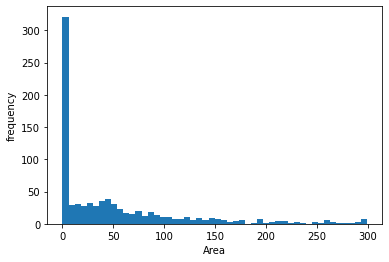

In [9]:
nodulesize=[np.sum(mask) for mask in nodulemasks]
plt.hist([nod for nod in nodulesize if nod<300],bins=50)
plt.xlabel("Area")
plt.ylabel("frequency")
plt.show()
#remove samples with nodulesize<25, which is ~radius=2.8
#filteredindicies=[i for i in range(len(nodulesize)) if nodulesize[i]>25]
#noduleimages=noduleimages[filteredindicies]
#nodulemasks=nodulemasks[filteredindicies]



In [10]:
# noduleimages=noduleimages.reshape(noduleimages.shape[0],1,512,512)
# nodulemasks=nodulemasks.reshape(nodulemasks.shape[0],1,512,512)

if K.image_data_format()=='channels_last':
    noduleimages=noduleimages.reshape(noduleimages.shape[0],512,512,1)
    nodulemasks=nodulemasks.reshape(nodulemasks.shape[0],512,512,1)
else:
    noduleimages=noduleimages.reshape(noduleimages.shape[0],1,512,512)
    nodulemasks=nodulemasks.reshape(nodulemasks.shape[0],1,512,512)


imagestrain, imagestest, maskstrain, maskstest = train_test_split(noduleimages,nodulemasks,test_size=.20)

maskstrain.shape



(808, 1, 512, 512)

In [11]:
# if K.image_data_format()=='channels_last':
#     maskstest = np.reshape( maskstest, [14, 512, 512,1])
#     imagestest = np.reshape( imagestest, [14, 512, 512,1])
#     imagestrain = np.reshape( imagestest, [14, 512, 512,1])
#     maskstrain = np.reshape( imagestest, [14, 512, 512,1])

# maskstrain.shape


In [12]:

# if K.image_data_format()=='channels_last':
#     plt.imshow(np.squeeze(maskstest[0]),cmap="gray")
# else:
#     plt.imshow(maskstest[0,0],cmap="gray")

Ground Truth test


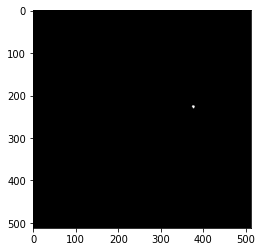

Image test


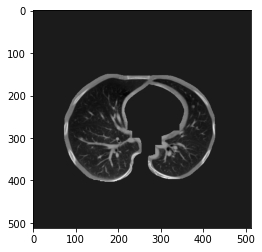

Ground Truth test


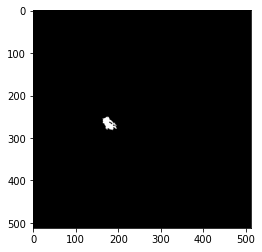

Image test


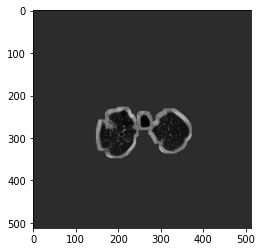

Ground Truth test


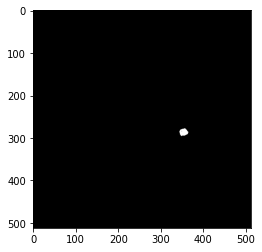

Image test


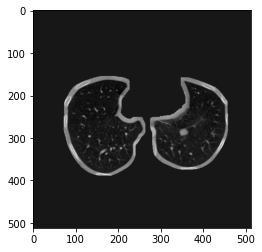

Ground Truth test


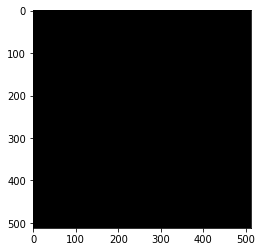

Image test


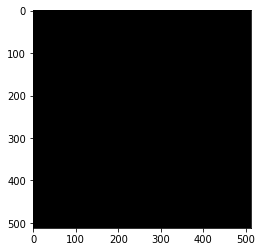

Ground Truth test


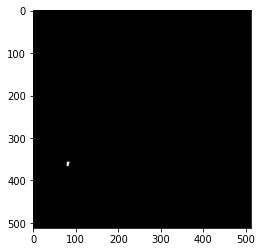

Image test


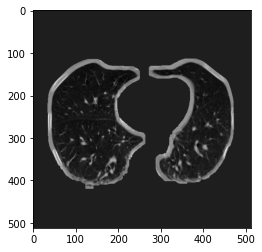

Ground Truth test


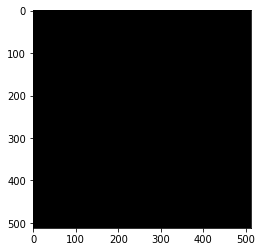

Image test


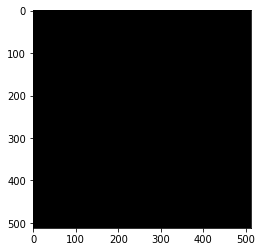

Ground Truth test


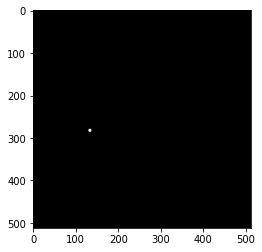

Image test


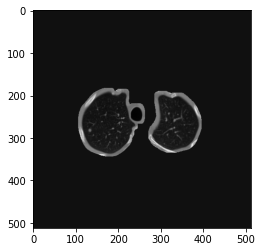

Ground Truth test


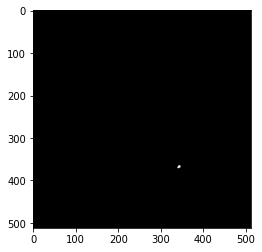

Image test


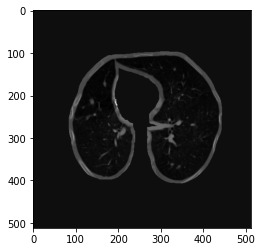

Ground Truth test


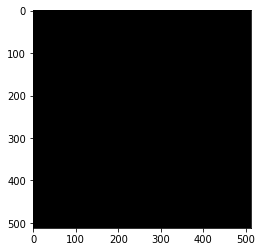

Image test


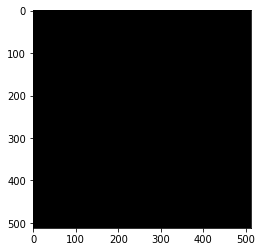

Ground Truth test


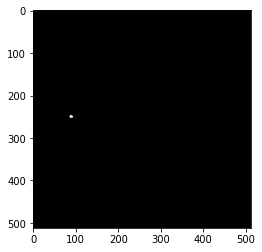

Image test


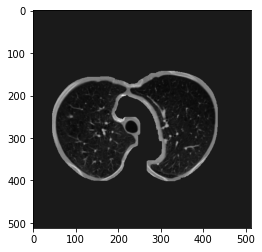

Ground Truth train


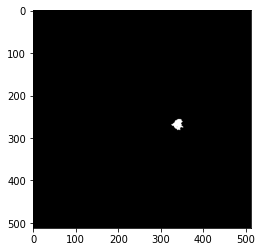

Image train


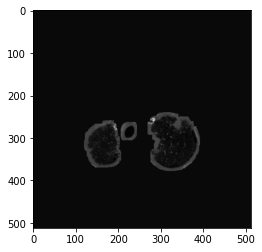

Ground Truth train


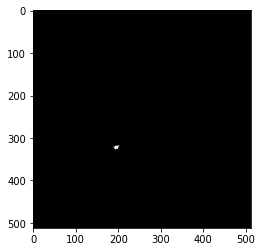

Image train


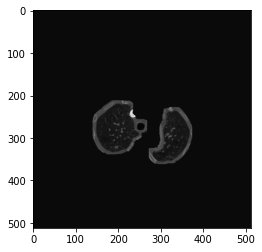

Ground Truth train


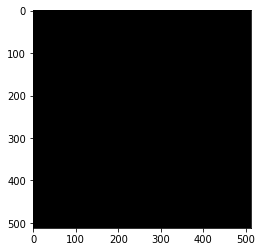

Image train


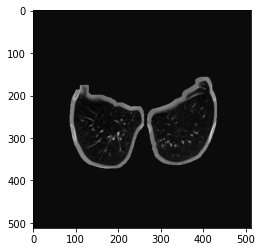

Ground Truth train


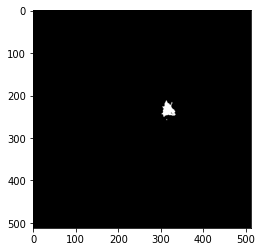

Image train


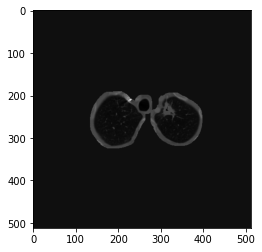

Ground Truth train


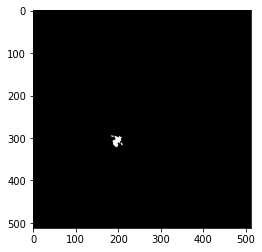

Image train


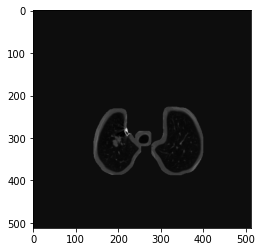

Ground Truth train


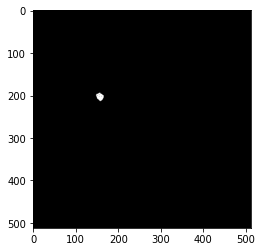

Image train


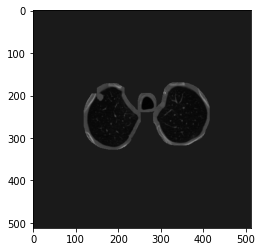

Ground Truth train


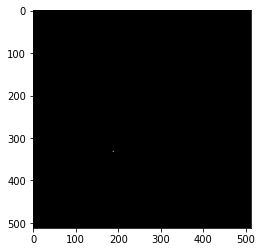

Image train


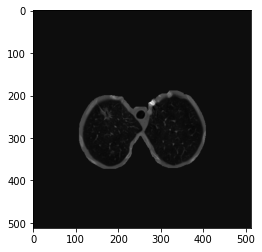

Ground Truth train


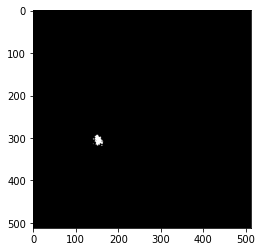

Image train


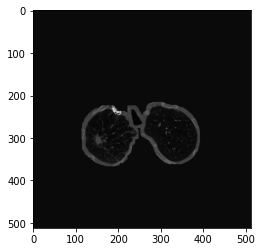

Ground Truth train


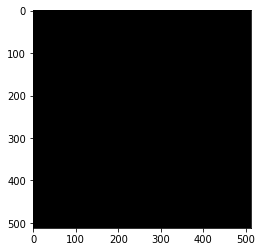

Image train


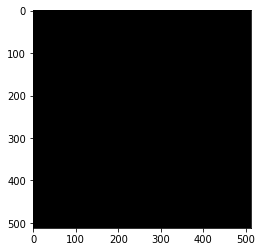

Ground Truth train


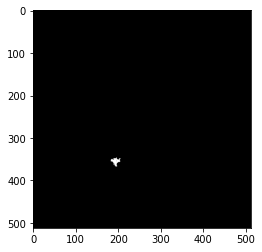

Image train


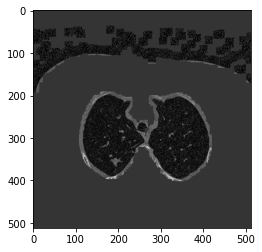

In [13]:

num_test=imagestest.shape[0]
num_train=imagestrain.shape[0]

num_test=10
num_train=10
if K.image_data_format()=='channels_last':
    for index in range(num_test):
        print("Ground Truth test")
        plt.imshow(np.squeeze(maskstest[index]),cmap="gray")
        plt.show()
        print("Image test")
        plt.imshow(np.squeeze(imagestest[index]), cmap="gray")
        plt.show()
            
    for index in range(num_test):
        print("Ground Truth train")
        plt.imshow(np.squeeze(maskstrain[index]),cmap="gray")
        plt.show()
        print("Image train")
        plt.imshow(np.squeeze(imagestrain[index]), cmap="gray")
        plt.show()
else:
    for index in range(num_test):
        print("Ground Truth test")
        plt.imshow(maskstest[index,0],cmap="gray")
        plt.show()
        print("Image test")
        plt.imshow(imagestest[index,0], cmap="gray")
        plt.show()
            
    for index in range(num_test):
        print("Ground Truth train")
        plt.imshow(maskstrain[index,0],cmap="gray")
        plt.show()
        print("Image train")
        plt.imshow(imagestrain[index,0], cmap="gray")
        plt.show()



In [14]:
#Code sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
smooth = 1.0
width = 32

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [15]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    
    if K.image_data_format()=='channels_first':
        input_shape = (1,512, 512)
        print((1,512, 512))
    else:
        input_shape = (512, 512,1)
        print((512, 512,1))

    inputs = Input(input_shape)

    ### [First half of the network: downsampling inputs] ###
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Build model
model = get_model((512,512), 1)
model.summary()

(1, 512, 512)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 512, 512) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 256, 256) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 256, 256) 1024        conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 256, 256) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [16]:

# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")


In [17]:
# Train model on dataset with only nodules
# mode=unet_model()
filepath=weightsfolder+"/unet-"+K.image_data_format()+"-weights-improvement_2.hdf5"
#model.load_weights(filepath)

# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',dice_coef])
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'accuracy'])


checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
history=model.fit(imagestrain, maskstrain, batch_size=4, epochs=10, verbose=1, shuffle=True,
              callbacks=[checkpoint],validation_data=(imagestest,maskstest))
#history=model.fit_generator(generator(batch_size=batchsize), steps_per_epoch=len(nonzeroindex)/batchsize-batchsize*11, nb_epoch=1, callbacks=callbacks_list)

Epoch 1/10
202/202 [==============================] - 98s 297ms/step - loss: -0.0052 - dice_coef: 0.0052 - accuracy: 0.0015 - val_loss: -0.0010 - val_dice_coef: 0.0010 - val_accuracy: 0.0000e+00

Epoch 00001: loss improved from inf to -0.00769, saving model to /content/drive/MyDrive/out/LungNoduleDetectionClassification/0001_0120/modelweights/unet-channels_first-weights-improvement_2.hdf5
Epoch 2/10
202/202 [==============================] - 59s 293ms/step - loss: -0.0126 - dice_coef: 0.0126 - accuracy: 0.0039 - val_loss: -0.0017 - val_dice_coef: 0.0017 - val_accuracy: 1.7318e-04

Epoch 00002: loss improved from -0.00769 to -0.01343, saving model to /content/drive/MyDrive/out/LungNoduleDetectionClassification/0001_0120/modelweights/unet-channels_first-weights-improvement_2.hdf5
Epoch 3/10
202/202 [==============================] - 60s 297ms/step - loss: -0.0133 - dice_coef: 0.0133 - accuracy: 0.0022 - val_loss: -0.0114 - val_dice_coef: 0.0114 - val_accuracy: 9.6213e-04

Epoch 00003: lo

In [18]:
# # Train model on dataset with only nodules
# umode=unet_model()
# filepath=weightsfolder+"/umode_unet-weights-improvement_2.hdf5"
# #model.load_weights(filepath)

# umode.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',dice_coef])
# # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])


# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
# history=umode.fit(imagestrain, maskstrain, batch_size=4, epochs=20, verbose=1, shuffle=True,
#               callbacks=[checkpoint],validation_data=(imagestest,maskstest))
# #history=model.fit_generator(generator(batch_size=batchsize), steps_per_epoch=len(nonzeroindex)/batchsize-batchsize*11, nb_epoch=1, callbacks=callbacks_list)

dict_keys(['loss', 'dice_coef', 'accuracy', 'val_loss', 'val_dice_coef', 'val_accuracy'])


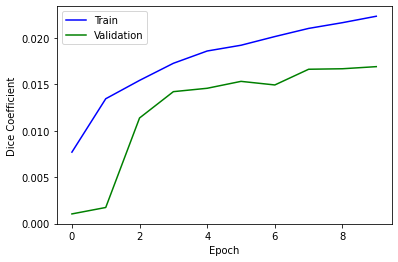

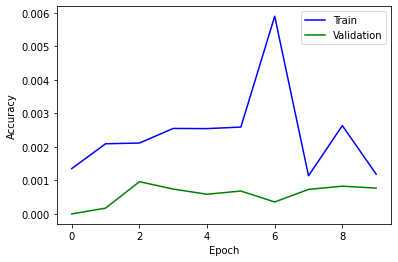

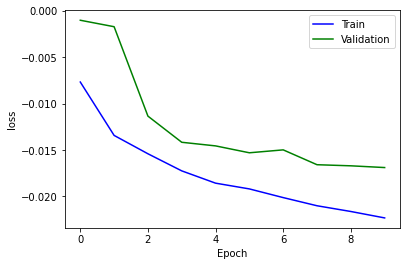

In [19]:
history
print(history.history.keys())
# model.save(weightsfolder+"/unet-weights-improvement_2_last.hdf5")
plt.plot(history.history['dice_coef'], color='b')
plt.plot(history.history['val_dice_coef'], color='g')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.legend(["Train", "Validation"])
plt.show()


plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='g')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='g')
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(["Train", "Validation"])
plt.show()

In [20]:
model.evaluate(imagestest,maskstest, batch_size=4)

51/51 [==============================] - 4s 71ms/step - loss: -0.0169 - dice_coef: 0.0169 - accuracy: 7.6970e-04


[-0.016894306987524033, 0.016890326514840126, 0.0007697044056840241]

In [21]:
imagestest.shape

# imagestest[1][360:375, 300:330]

(203, 1, 512, 512)

In [26]:

if K.image_data_format()=='channels_last':

    num_test=imagestest.shape[0]
    imgs_mask_test = np.ndarray([num_test,512,512,1],dtype=np.float32)

    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imagestest[i:i+1]], verbose=0)[0]

    print(imgs_mask_test.shape)

    sumoverlap=[]
    for i in range(num_test):
        sumoverlap.append(np.sum(maskstest[i]*imgs_mask_test[i]))

    #nodulemasks
    print(len([ov for ov in sumoverlap if ov>1])/len(sumoverlap))

else:
    num_test=imagestest.shape[0]
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)

    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imagestest[i:i+1]], verbose=0)[0]

    # print(imgs_mask_test.shape)

    sumoverlap=[]
    for i in range(num_test):
        sumoverlap.append(np.sum(maskstest[i,0]*imgs_mask_test[i,0]))

    #nodulemasks
    print(len([ov for ov in sumoverlap if ov>1])/len(sumoverlap))

(203, 1, 512, 512)
0.4433497536945813


Predicted


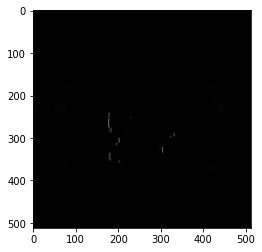

Ground Truth


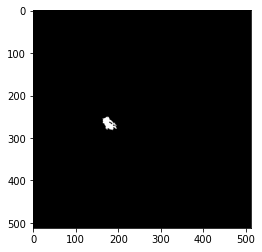

Image


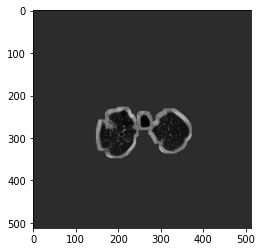

In [23]:
#Visualize prediction mask

index=1

if K.image_data_format()=='channels_last':
    print("Predicted")
    plt.imshow(np.squeeze(imgs_mask_test[index]), cmap="gray")
    plt.show()
    print("Ground Truth")
    plt.imshow(np.squeeze(maskstest[index]),cmap="gray")
    plt.show()
    print("Image")
    plt.imshow(np.squeeze(imagestest[index]), cmap="gray")
    plt.show()
else:
    print("Predicted")
    plt.imshow(imgs_mask_test[index,0], cmap="gray")
    plt.show()
    print("Ground Truth")
    plt.imshow(maskstest[index,0],cmap="gray")
    plt.show()
    print("Image")
    plt.imshow(imagestest[index,0], cmap="gray")
    plt.show()




TESTY bez znaczenia !!!

In [ ]:
filepath=weightsfolder+"/unet-weights-improvement_2.hdf5"

load_status = model.load_weights(filepath)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',dice_coef])

# fmodel = tf.keras.models.load_model(filepath)
model.evaluate(imagestest,maskstest, batch_size=4)

In [ ]:
# noduleimages=np.load(datafolder+"/noduleimages2.npy")
# nodulemasks=np.load(datafolder+"/nodulemasks2.npy")

for i in range(20):
    print(i)
    plt.imshow(noduleimages[i],cmap="gray")
    plt.show()
    plt.imshow(nodulemasks[i], cmap="gray")
    plt.show()
    # plt.imshow(nodulemaskscircle[i], cmap="gray")
    # plt.show()
    plt.imshow(noduleimages[i]*nodulemasks[i])
    plt.show()
    print("------------------------------------------")